# Preliminaries

## Import Packages

In [19]:
#--Basics---------------
import pandas as pd
import numpy as np

#--Data Visualization----
import matplotlib.pyplot as plt
import seaborn as sns

#---Scikit-Learn--------
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MaxAbsScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, Lasso
from sklearn.impute import SimpleImputer
from sklearn.utils import estimator_html_repr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

#---Misc------------------
from mlxtend.feature_selection import SequentialFeatureSelector as MLSeqFeatSelector

## Define Data

In [2]:
data = pd.read_csv(r"ames.csv")
data.to_csv("df.csv")
def numeric_categorical_attributes(data):
    numeric, categorical = ([], [])
    for col in data.columns:
        try:
            data[col].apply(pd.to_numeric)
            numeric.append(col)
        except:
            categorical.append(col)
    return (numeric, categorical)

cols_numeric, cols_categorical = numeric_categorical_attributes(data.drop(columns = ["price"]))


# Exploratory Data Analysis

## See What Columns Have Too Many Nulls

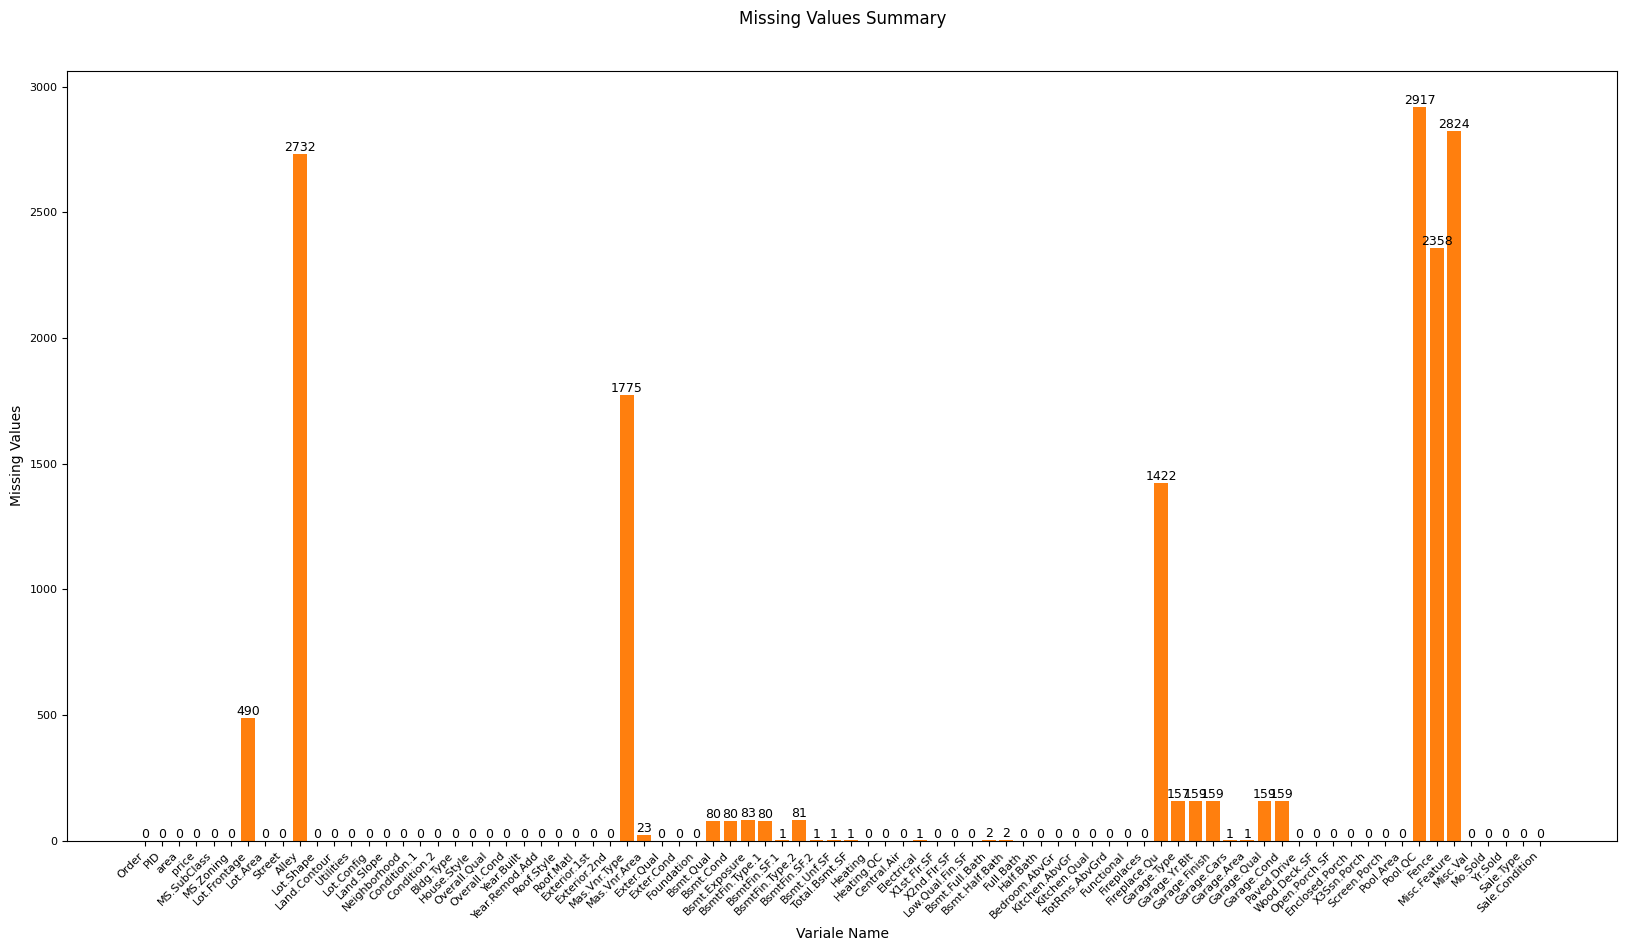

In [7]:
# Check for missing values
missing_values = data.isnull().sum()

# Creat the figure and specify the size
plt.figure(figsize=(20, 10))

# Create the bar chart
bars = plt.bar(missing_values.index, missing_values.values)
plt.bar(missing_values.index, missing_values.values)
plt.xlabel('Variale Name')
plt.ylabel('Missing Values')
plt.title('Missing Values Summary', y=1.05)

# Rotate x-axis labels for better visibility and reduce font size
plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust the rotation angle and font size as needed
plt.yticks(fontsize=8)

# Add the actual values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black', fontsize=9)

# Save the plot as an image (PNG format in this example)
#plt.savefig('Ams_missing_values_plot.png', bbox_inches='tight')

plt.show()

The column with missing values percentage[Alley= 93%, Fireplace.Qu= 49%, Pool.QC= 99.6% Fence=80%, Misc.Feature=96.4%]

## Pair Plots

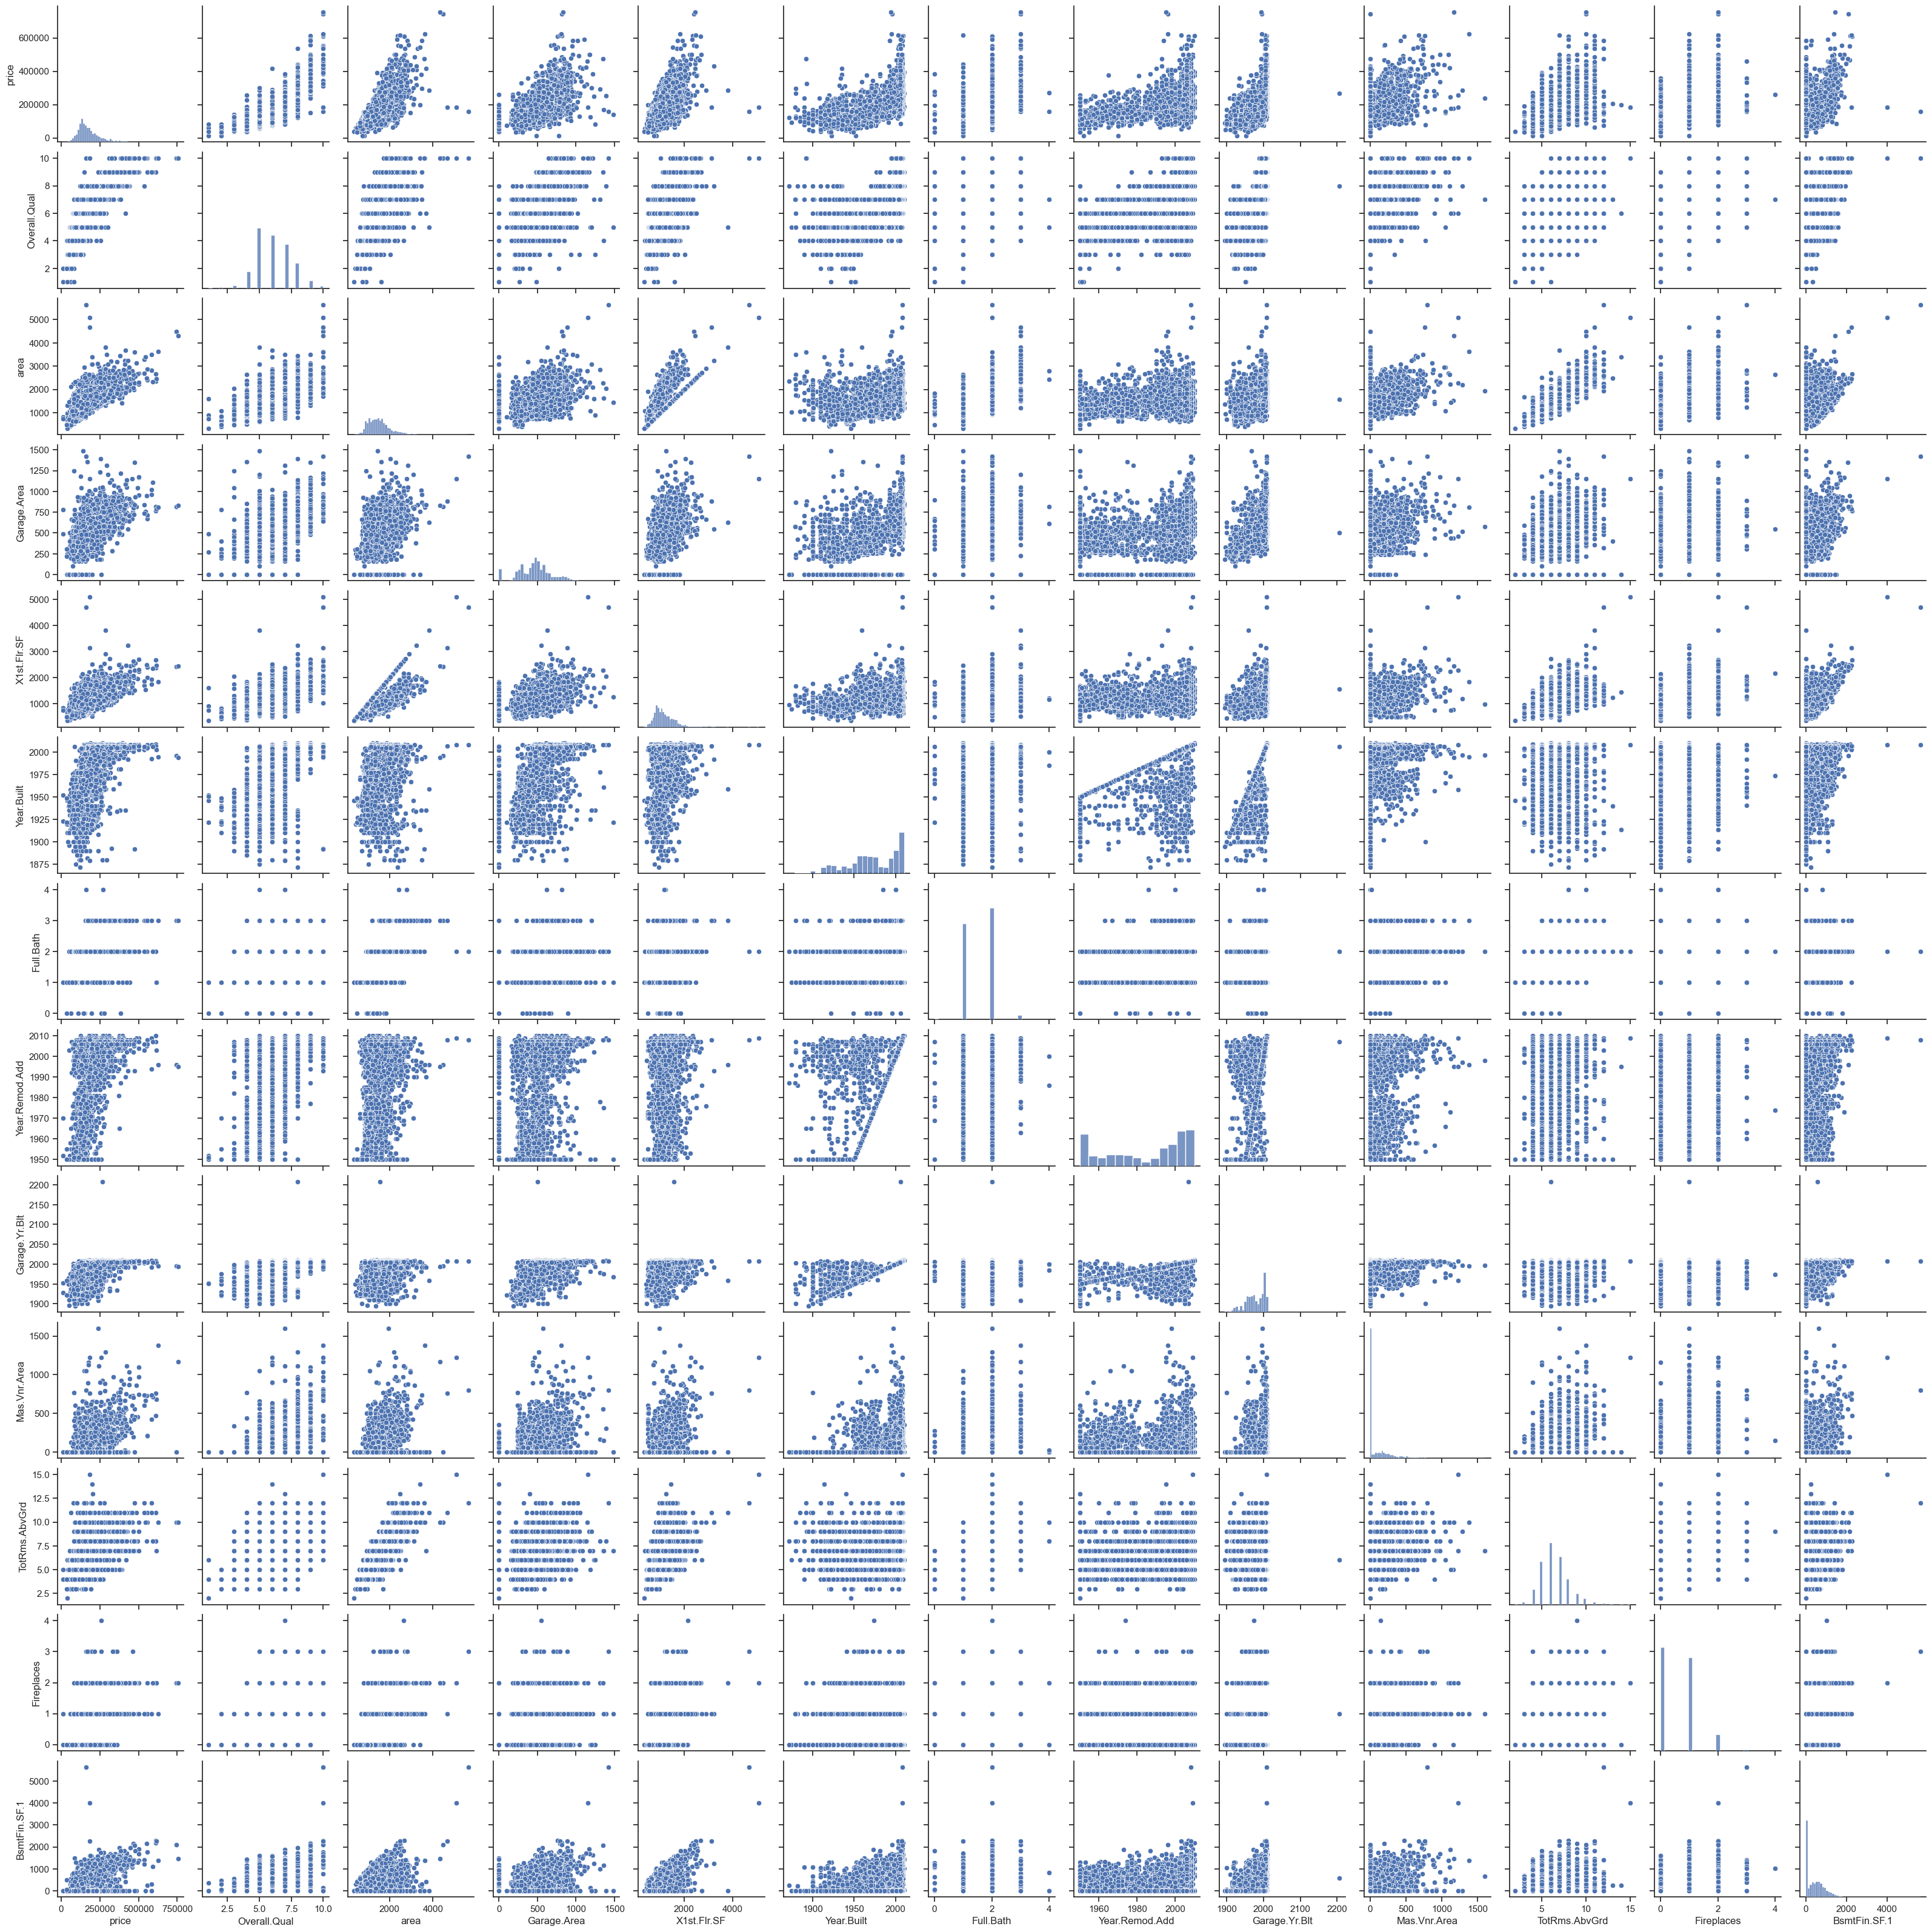

In [8]:
sns.set(style="ticks")
cols = ['price', 'Overall.Qual', 'area', 'Garage.Area', 'X1st.Flr.SF', 'Year.Built', 'Full.Bath', 'Year.Remod.Add', 'Garage.Yr.Blt', 'Mas.Vnr.Area', 'TotRms.AbvGrd', 'Fireplaces', 'BsmtFin.SF.1']
sns.pairplot(data[cols], height = 2.5)
plt.show()

## Correlation Matrix

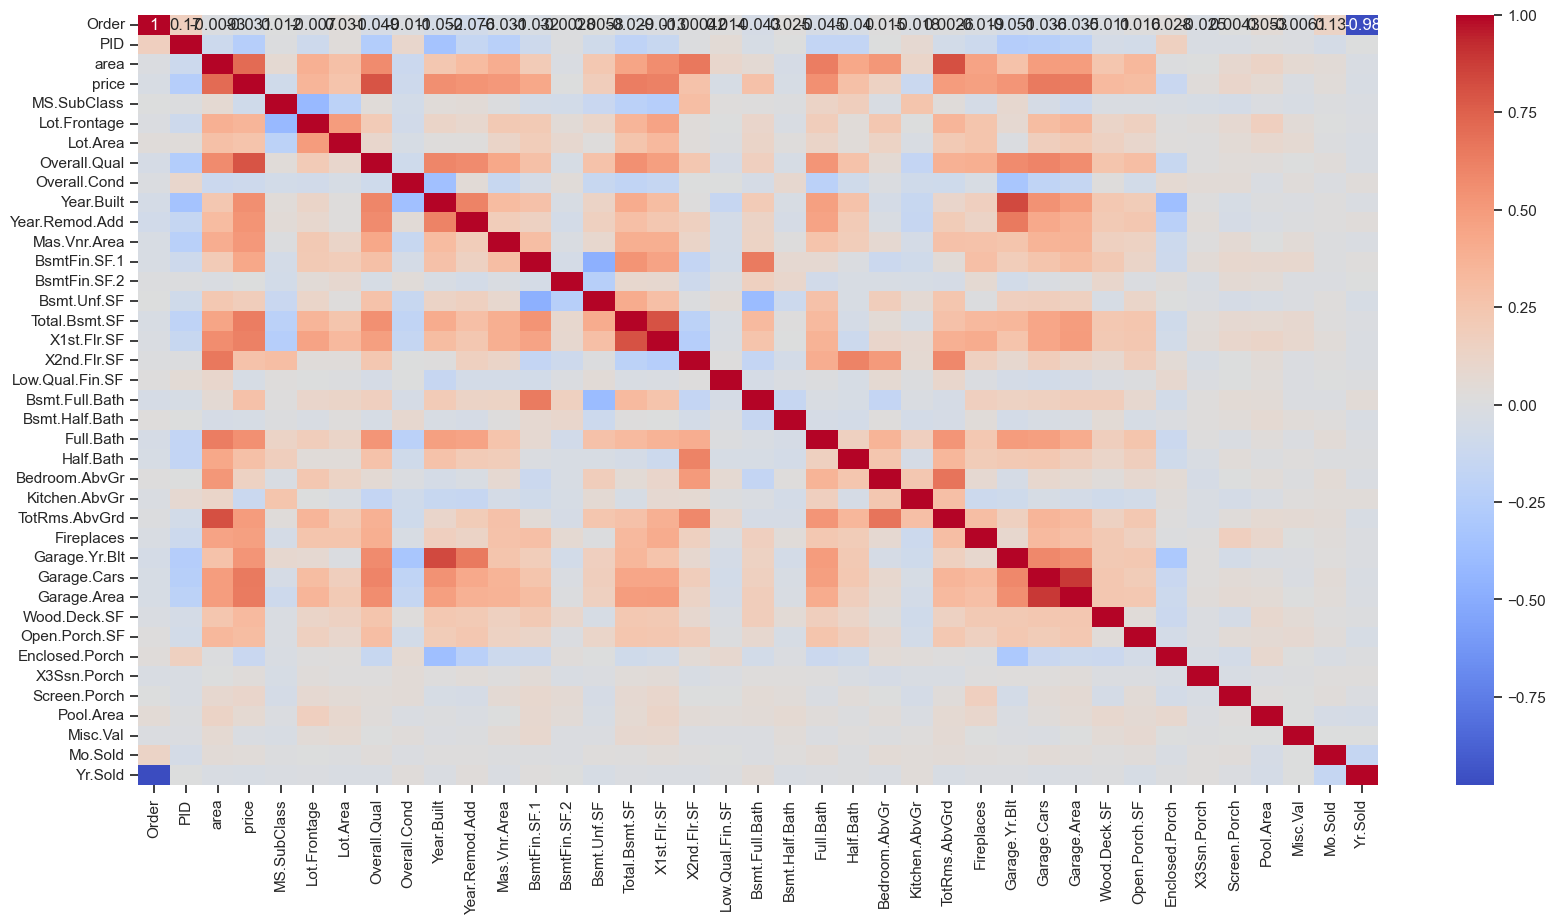

In [12]:
# Calculate the correlation matrix
correlation_matrix = data.corr(numeric_only=True)
# Create a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

## Scatterplots and Boxplots to See Correlations

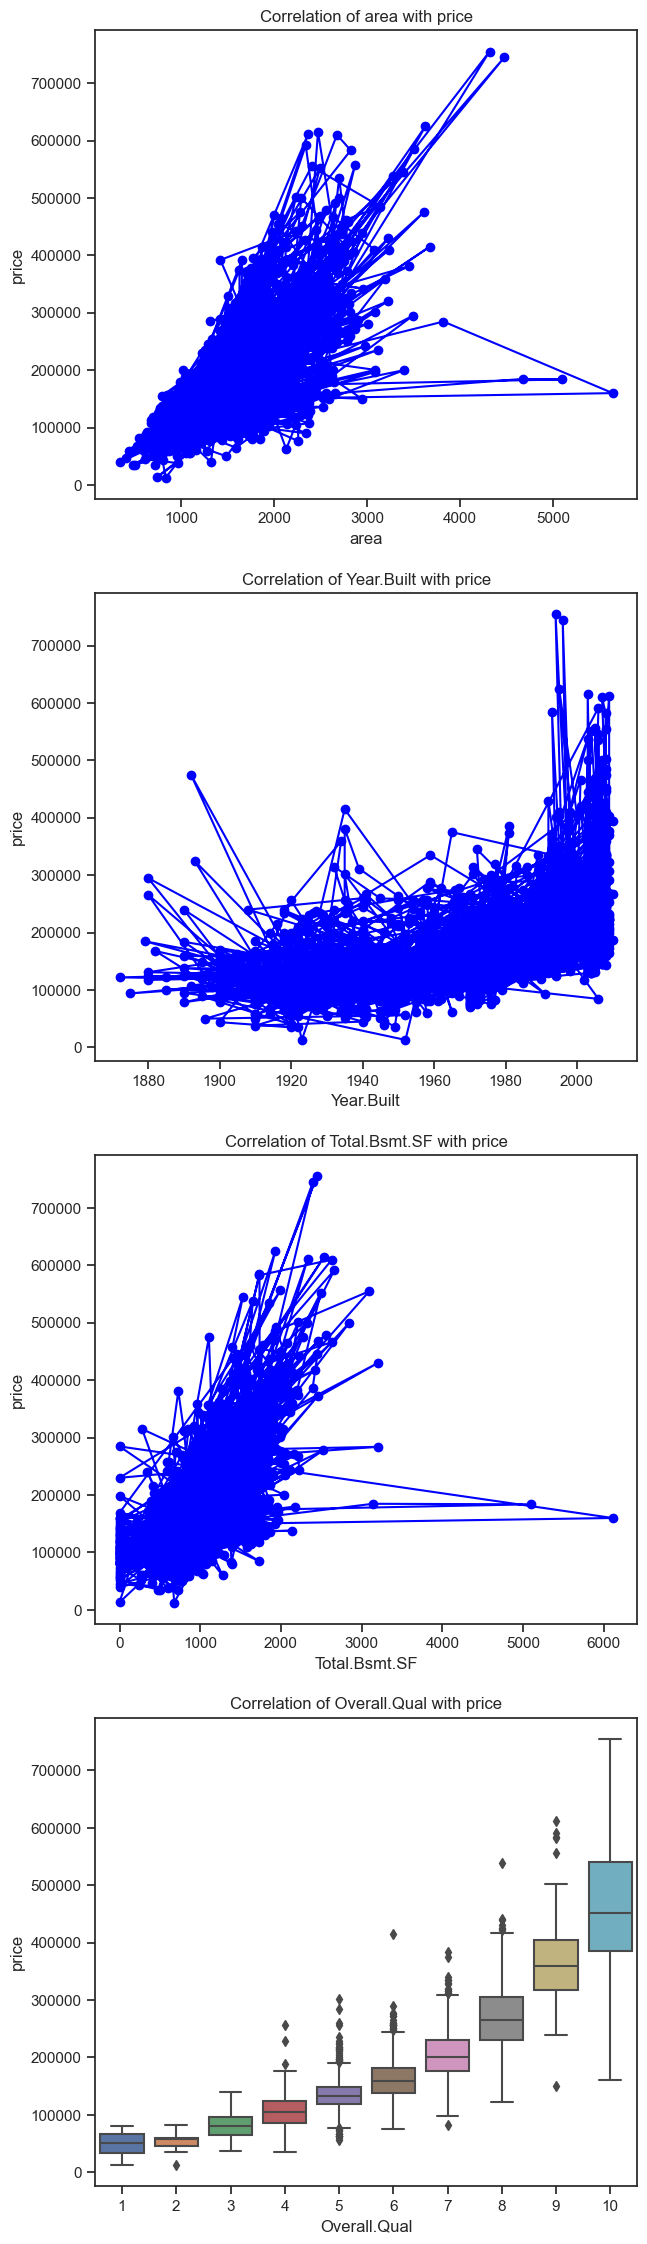

In [13]:
def scatterplots(data, features_num, features_cat, target, size = 7):
    n_num, n_cat = (len(features_num), len(features_cat))
    n = n_num + n_cat
    plt.figure(1, figsize = (size, size * n))
    for i in range(n_num):
        ax = plt.subplot(n, 1, i + 1)
        ax.title.set_text("Correlation of {} with {}".format(features_num[i], target))
        plt.plot(data[features_num[i]], data[target], **{'color': 'blue', 'marker': 'o'})
        plt.xlabel(features_num[i])
        plt.ylabel(target)
    for i in range(n_cat):
        ax = plt.subplot(n, 1, i + 1 + n_num)
        ax.title.set_text("Correlation of {} with {}".format(features_cat[i], target))
        df = pd.concat([data[features_cat[i]], data[target]], axis=1)
        sns.boxplot(x = features_cat[i], y = target, data = df, ax = ax)
        plt.xlabel(features_cat[i])
        plt.ylabel(target)
    plt.show()

scatterplots(data_2, ["area", "Year.Built", "Total.Bsmt.SF"], ["Overall.Qual"], "price")

For Overall.Qual values are
      10 Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor.

  From this we can see the very excellent quality of houses has the most price

# Data Cleaning

## Handle Missing Values

In [14]:
def clean_out_nulls(data, drop_cols, cols_numeric, cols_categorical):
    # Drop columns that have many nulls.
    result = data.drop(columns=drop_cols, axis=1)
    new_cols_numeric, new_cols_categorical = [list(set(cols).difference(drop_cols)) for cols in [cols_numeric, cols_categorical]]
    # Impute missing values with the median of the respective column
    for col in new_cols_numeric:
        median_value = data[col].median()
        result[col] = data[col].fillna(median_value)  
    # Impute missing values with the mode of the respective column
    for col in new_cols_categorical:
        result[col] = data[col].fillna(data[col].mode()[0])
    
    return (result, new_cols_numeric, new_cols_categorical)

drop_cols = ['Alley', 'Fireplace.Qu', 'Pool.QC', 'Fence', 'Misc.Feature']
data_1, cols_numeric, cols_categorical = clean_out_nulls(data, drop_cols, cols_numeric, cols_categorical)



## Encoding

In [15]:
def one_hot_encoding(data, cols_numeric, cols_categorical, target):
    encoder = OneHotEncoder(sparse_output = False).set_output(transform="pandas")
    X_ohe_cat = encoder.fit_transform(data[cols_categorical])
    return pd.concat([X_ohe_cat, data[cols_numeric + [target]]], axis=1)

data_2 = one_hot_encoding(data_1, cols_numeric, cols_categorical, "price")


## Standard Scaling

In [16]:
def std_scaling(data, target):
    scaler = StandardScaler().set_output(transform="pandas")
    return pd.concat([scaler.fit_transform(data.drop(target, axis=1)), data[target]], axis=1)

data_3 = std_scaling(data_2, "price")
data_3

,Bsmt.Qual_Ex,Bsmt.Qual_Fa,Bsmt.Qual_Gd,Bsmt.Qual_Po,Bsmt.Qual_TA,Condition.1_Artery,Condition.1_Feedr,Condition.1_Norm,Condition.1_PosA,Condition.1_PosN,...,Lot.Frontage,MS.SubClass,Bsmt.Unf.SF,Bsmt.Full.Bath,Screen.Porch,X1st.Flr.SF,Fireplaces,BsmtFin.SF.1,Mas.Vnr.Area,price
0,-0.310736,-0.175966,-0.844067,-0.026135,1.072227,-0.180048,-0.243498,0.402214,-0.082903,-0.116147,...,3.375742,-0.877005,-0.269105,1.084376,-0.285354,1.267003,2.162180,0.431223,0.061046,215000
1,-0.310736,-0.175966,-0.844067,-0.026135,1.072227,-0.180048,4.106806,-2.486237,-0.082903,-0.116147,...,0.514952,-0.877005,-0.658319,-0.821576,1.854530,-0.672643,-0.925143,0.055760,-0.566039,105000
2,-0.310736,-0.175966,-0.844067,-0.026135,1.072227,-0.180048,-0.243498,0.402214,-0.082903,-0.116147,...,0.561850,-0.877005,-0.348769,-0.821576,-0.285354,0.432445,-0.925143,1.054800,0.038650,172000
3,-0.310736,-0.175966,-0.844067,-0.026135,1.072227,-0.180048,-0.243498,0.402214,-0.082903,-0.116147,...,1.124628,-0.877005,1.105661,1.084376,-0.285354,2.425687,2.162180,1.366588,-0.566039,244000
4,-0.310736,-0.175966,1.184740,-0.026135,-0.932639,-0.180048,-0.243498,0.402214,-0.082903,-0.116147,...,0.233563,0.061285,-0.961040,-0.821576,-0.285354,-0.590974,0.618518,0.764969,-0.566039,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,-0.310736,-0.175966,-0.844067,-0.026135,1.072227,-0.180048,-0.243498,0.402214,-0.082903,-0.116147,...,-1.501671,0.530430,-0.854064,1.084376,-0.285354,-0.399561,-0.925143,0.826448,-0.566039,142500
2926,-0.310736,-0.175966,1.184740,-0.026135,-0.932639,-0.180048,-0.243498,0.402214,-0.082903,-0.116147,...,-0.047827,-0.877005,-0.728878,1.084376,-0.285354,-0.657330,-0.925143,-0.310920,-0.566039,131000
2927,-0.310736,-0.175966,1.184740,-0.026135,-0.932639,-0.180048,-0.243498,0.402214,-0.082903,-0.116147,...,-0.329216,0.647716,0.035893,-0.821576,-0.285354,-0.483783,-0.925143,-0.231876,-0.566039,132000
2928,-0.310736,-0.175966,1.184740,-0.026135,-0.932639,-0.180048,-0.243498,0.402214,-0.082903,-0.116147,...,0.374257,-0.877005,-0.829026,1.084376,-0.285354,0.585575,0.618518,1.379762,-0.566039,170000


# Feature Selection

Our processed data has 77 variables and 2930 observations. we want to perform feature selection on the data in order to determine which variables are most significant for different models based on the accuracy of the models. This will enable us to do better predictions for your organization in terms of determining the housing prices.

## Find Features With Highest Correlation to Target

In [17]:
def top_corr_features(data, target, num_features):
    #Feature selection based on correlation matrix value
    correlation_matrix = data.corr()
    top_correlations = correlation_matrix[target].abs().nlargest(num_features)
    return top_correlations.index

print("The top 10 most correlated attributes with respect \
to price are \n{}.".format("\n".join(list(top_corr_features(data_2, "price", 10)))))

The top 10 most correlated attributes with respect to price are 
price
Overall.Qual
area
Garage.Cars
Garage.Area
Total.Bsmt.SF
X1st.Flr.SF
Bsmt.Qual_Ex
Exter.Qual_TA
Year.Built.


## Forward Subset Selection (Fatima)

In [ ]:
def feat_selection_feats(data, target, forward, k_features):
    X_train, X_test, Y_train, Y_test = train_test_split(data.drop([target], axis=1), data[target], test_size=0.3, random_state=1)
    feat_select = MLSeqFeatSelector(LinearRegression(), k_features=k_features, forward=forward, floating=False,
                                                    verbose=2, scoring='r2', cv=10)
    feat_select.fit(X_train, Y_train)
    return feat_select.k_feature_names_


In [ ]:
forward_features = feat_selection_feats(data_3, "price", True, 38)

The best 10 features for our Linear regression Model as returned by Forward Selection are shown above. They are the features with the most significant impact according to our Forward Selection Algorithm

## Backward Subset Selection (Fatima)

In [79]:
backward_features = feat_selection_feats(data_3, "price", False, 10)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   39.1s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

The top 10 best features with the most significant as returned by our Backward Subset Selection is shown above. More than 90% of the features returned by Backward Selection are in the Forward Selection. 

## Forward Subset Selection (Ian)

In [84]:
def feat_selection_feats2(data, target, forward, tolerance):
    direction = "forward" if forward else "backward"
    feat_select = SequentialFeatureSelector(estimator=LinearRegression(), direction=direction, tol=tolerance).set_output(transform="pandas")
    return feat_select.fit_transform(data.drop(target, axis=1), data[target]).columns

In [83]:
feat_selection_feats2(data_3, "price", True, .001)

Index(['Land.Contour_Bnk', 'Bldg.Type_2fmCon', 'Kitchen.Qual_Ex',
       'Bsmt.Qual_Ex', 'Neighborhood_Crawfor', 'Neighborhood_GrnHill',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Exter.Qual_Ex', 'Bsmt.Exposure_Av',
       'Bsmt.Exposure_Gd', 'Roof.Matl_WdShngl', 'area', 'Garage.Cars',
       'Overall.Cond', 'Fireplaces', 'Overall.Qual', 'Screen.Porch',
       'Year.Built', 'BsmtFin.SF.1', 'MS.SubClass'],
      dtype='object')

## Backward Selection (Ian)

In [86]:
feat_selection_feats2(data_3, "price", False, 0.001)

KeyboardInterrupt: 

# Data Regularization

We have decided to use the union of the best 10 predictors returned by both forward and backward subset selection to fit a simple linear model. 

In [10]:
predictors_to_use = ['area', 'MS.SubClass', 'Overall.Qual', 'Year.Built', 
                     'Year.Remod.Add', 'Mas.Vnr.Area', 'Bsmt.Full.Bath', 
                     'Fireplaces', 'Garage.Cars', 'Screen.Porch', 'BsmtFin.SF.1']

## Standard Regression

In [19]:
def regression(data, target, predictors = None):
    X = data.drop(target, axis=1) if predictors is None else data[predictors]
    X_train, X_test, Y_train, Y_test = train_test_split(X, data[target], test_size = 0.3, random_state=1)
    reg = LinearRegression()
    reg.fit(X_train, Y_train)
    return reg, reg.score(X_test, Y_test)


In [20]:
regression(data_3, "price", predictors_to_use)

(LinearRegression(), 0.8427447741655747)

It could be seen that our fitted linear model on the selected subset of features did performed well on both the testing data and the training data. 

In [21]:
regression(data_3, "price")

(LinearRegression(), -1.5804481689919822e+24)

So we tried to fit our linear regression in all the 38 numerical values in the dataset in order to check if our linear regression model will over_fit the data. However, Overfitting did not occur as the model did pretty well in evaluating the tested data. We will go ahead and do Lasso and Ridge regression in all the 38 numerical values of the dataset and see if we will get better test performance.

## Lasso Regression

In [23]:
def lasso(data, target, alpha, tolerance, predictors = None):
    X = data.drop(target, axis=1) if predictors is None else data[predictors]
    X_train, X_test, Y_train, Y_test = train_test_split(X, data[target], test_size = 0.3, random_state=1)
    lasso_reg = Lasso(alpha=alpha, max_iter=100, tol=tolerance)
    lasso_reg.fit(X_train, Y_train)
    return lasso_reg, lasso_reg.score(X_test, Y_test)

In [36]:
lasso(data_3, "price", 50, 0.1, predictors_to_use)[1]


0.8374349369621584

The prediction accuracy of the L1 Regularization (Lasso) performed similarly to our Linear Regression model and didn't do better than the Linear model. 

In [35]:
lasso(data_3, "price", 50, 0.1)[1]

0.9021881753890836

It could be seen that Lasso regression model performed similarly to our Linear Regression model in both the training and testing of all the numerical features in the dataset. Thus, we can confident that our linear model will perform a good prediction with atleast 85% accuracy when fittend in either the subset returned by the forward selection or on all the 38 numerical variables in the dataset. 

Since the performance of the model with few subset selected of about 11 is similar to the performance of the model with all the 38 features selected. We can say that fitting the model to the eleven selected features preserve as much information provided by the 38 numerical attributes.

## Ridge Regression

In [33]:
def ridge(data, target, alpha, tolerance, predictors = None):
    X = data.drop(target, axis=1) if predictors is None else data[predictors]
    X_train, X_test, Y_train, Y_test = train_test_split(X, data[target], test_size = 0.3, random_state=1)
    ridge_reg = Ridge(alpha=alpha, max_iter=100, tol=tolerance)
    ridge_reg.fit(X_train, Y_train)
    return ridge_reg, ridge_reg.score(X_test, Y_test)

In [34]:
ridge(data_3, "price", 50, 0.1, predictors_to_use)[1]

0.8418809001593126

Similarly, the prediction accuracy of the L2 Regularization (The Ridge) performed similarly to our Linear Regression model as well as the L1 Regularization (The Lasso) and din't do bette than the Linear model. We can concluse that the Linear Model is a good fit to the selected features and has a reasonable amount of prediction accuracy.

# Dimensionality Reduction

## Principal Component Analysis (PCA)

In [27]:
def pca(data, target, n_components):
    pca_model = PCA(n_components=n_components).set_output(transform="pandas")
    pca_df = pca_model.fit_transform(data.drop(target, axis=1))
    transformed_data = pd.concat([pca_df, data[target]], axis=1)
    return transformed_data, pca_model.explained_variance_ratio_

In [29]:
data_pca, exp_var = pca(data_3, "price", 2)
print(data_pca)
print(exp_var)

          pca0      pca1   price
0    -0.026780 -4.509992  215000
1    -3.226841 -2.978894  105000
2    -1.505421 -4.009135  172000
3     2.216309 -3.295228  244000
4     2.431423  0.537593  189900
...        ...       ...     ...
2925 -1.542901 -3.274996  142500
2926 -1.459814 -5.710386  131000
2927 -1.522330 -1.645119  132000
2928 -0.494913 -5.388181  170000
2929  2.217569 -0.873725  188000

[2930 rows x 3 columns]
[0.06345312 0.02785134]


Over 99% of the variation in the dataset can be explained by the First Principal Component. This shows that the variables are highly correlated with each other and the First Principal Componenent is enough to summarize the relationship really well.

## Principal Component Regression (PCR)

In [18]:
regression(data_pca, "price")[1]

NameError: name 'regression' is not defined

It can be seen that principal component subset selection does not perform well in both the training and testing accuracy. This is because Dimension reduction does not consider the response variable. It assumes that the linear combination of predictors with high variance is probably going to be associated with the response. However, there is no reason for that to be the case and infact it might not be.  

# Developing a Model Based on the Year-Built Feature

We intend to analyze how the target which is the Sale price of house in US Dollars varies with the year in which the house was originaly constructed. 

In [ ]:
def simplePolyReg(data, predictor, target, degree, plot = False):
    X_train, X_test, Y_train, Y_test = train_test_split(data[[predictor]], data[target], test_size = 0.3, random_state = 1)
    poly, model = PolynomialFeatures(degree=degree), LinearRegression()
    X_poly_train, X_poly_test = [poly.fit_transform(X) for X in [X_train, X_test]]
    model.fit(X_poly_train, Y_train)
    if plot:
        fig = plt.figure(figsize = (7, 7))
        ax = fig.add_subplot(111)
        coefs, intercept = model.coef_, model.intercept_
        ax.title.set_text("{} vs {} with Deg {} Fit".format(target, predictor, degree))
        ax.set_xlim([-5, 5])
        ax.set_ylim([0, 700000])
        plt.plot(data[predictor], data[target], **{"color":"green", "marker":'o'}, label = 'data')
        plt.legend()
        x_axis = np.arange(-5, 5, 0.5)
        fitted = intercept + coefs[1]*x_axis + coefs[2] * x_axis**2
        plt.plot(x_axis, fitted, **{"color":"red"}, label="fitted")
        plt.legend()
        plt.xlabel("{} (Scaled)".format(predictor))
        plt.ylabel(target)
        plt.show()
    else:
        return (model, model.score(X_poly_test, Y_test), model.score(X_poly_train, Y_train))


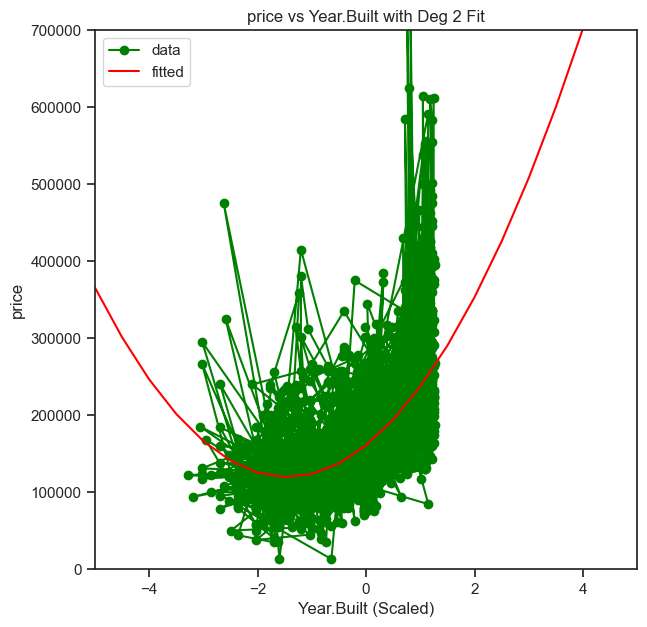

In [ ]:
simplePolyReg(data_3, "Year.Built", "price", 2, True)